In [1]:
from TDB_COMET_LTCR import COMET
from models.encoder import FTClassifier
# import datautils
from tasks.fine_tuning import finetune_fit
from tasks.fine_tuning import finetune_predict
from tasks.linear_evaluation import eval_classification
from dataloading.tdbrain_preprocessing import load_tdbrain
from config_files.TDBrain_Configs import Config as Configs
from dct_func import FFT_for_Period
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from utils_cpc import plot_channels # 
from utils_cpc import process_batch_ts
from utils_cpc import split_data_label
from utils_cpc import start_logging
from utils_cpc import stop_logging
from utils_cpc import seed_everything

from datetime import datetime

In [2]:
configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Specify saving and logging directory

In [3]:
working_directory = configs.working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

#### Load and preprocessing data

In [4]:
data_path = "datasets/TDBRAIN/Feature/"
label_path = "datasets/TDBRAIN/Label/label.npy"
train_ids = list(range(1,18)) + list(range(29,46))  # specify patient ID for training, validation, and test set
val_ids = [18, 19, 20, 21] + [46, 47, 48, 49]  # 8 patients, 4 positive 4 healthy
test_ids = [22, 23, 24, 25] + [50, 51, 52, 53]  # 8 patients, 4 positive 4 healthy"""
X_trial_train, X_trial_val, X_trial_test, y_trial_train, y_trial_val, y_trial_test = load_tdbrain(train_ids, val_ids, test_ids, data_path, label_path)
print(X_trial_train.shape)
print(y_trial_train.shape)
print(X_trial_val.shape)
print(y_trial_val.shape)
print(X_trial_test.shape)
print(y_trial_test.shape)

Validation subjects:  [18, 19, 20, 21, 46, 47, 48, 49]
Test subjects:  [22, 23, 24, 25, 50, 51, 52, 53]
(432, 2560, 33)
(432, 2)
(96, 2560, 33)
(96, 2)
(96, 2560, 33)
(96, 2)


In [5]:
# normalize data
X_trial_train = process_batch_ts(X_trial_train, normalized=True, bandpass_filter=False)
X_trial_val = process_batch_ts(X_trial_val, normalized=True, bandpass_filter=False)
X_trial_test = process_batch_ts(X_trial_test, normalized=True, bandpass_filter=False)
print(X_trial_train.shape)
print(X_trial_val.shape)
print(X_trial_test.shape)

(432, 2560, 33)
(96, 2560, 33)
(96, 2560, 33)


In [6]:
# periodicity, freq_list = FFT_for_Period(torch.tensor(X_trial_train), 8) # 
# periodicity = torch.from_numpy(np.array([periodicity]))
# # periodicity = periodicity.item()
# periodicity
# # tensor([[2560, 1280,  853,  640,  512,  426,  365,  320]])

In [7]:
# Split trail-level data into sample-level data
X_train, y_train = split_data_label(X_trial_train,y_trial_train, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_val, y_val = split_data_label(X_trial_val,y_trial_val, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_test, y_test = split_data_label(X_trial_test,y_trial_test, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(8208, 4)
(1824, 4)
(1824, 4)
(8208, 256, 33)
(1824, 256, 33)
(1824, 256, 33)
(8208, 4)
(1824, 4)
(1824, 4)


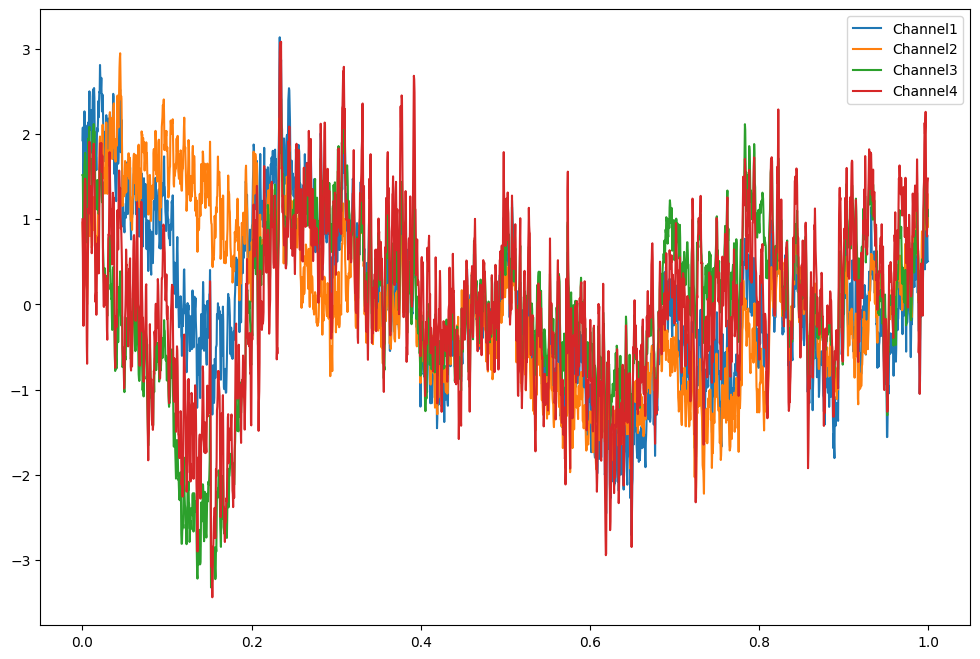

7

In [8]:
plot_channels(1, X_trial_train[1][:,:4])
y_trial_train[1][1]

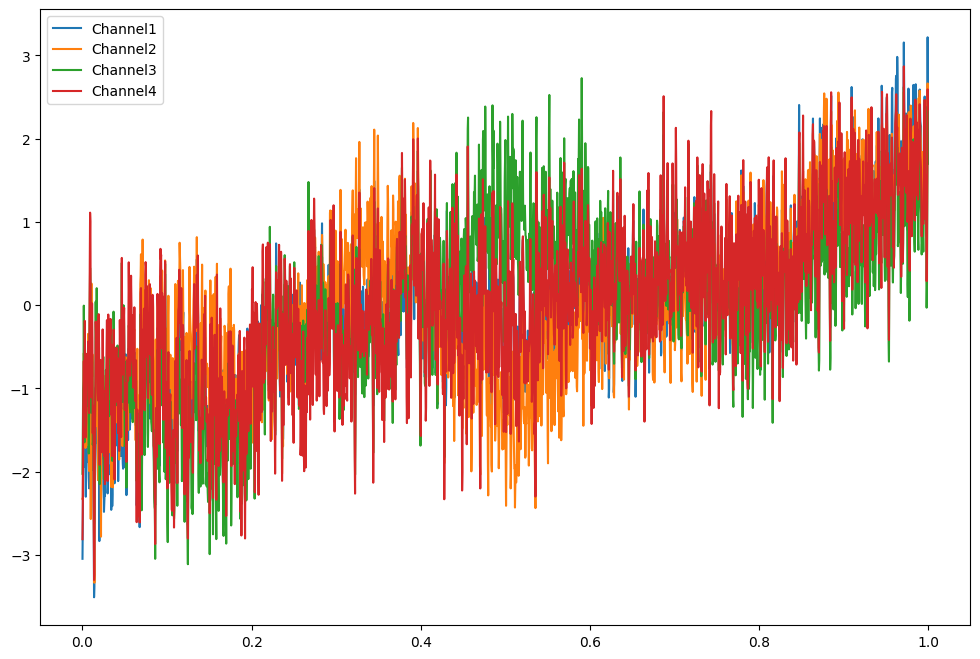

45

In [9]:
plot_channels(1, X_trial_train[0][:,:4])
y_trial_train[0][1]

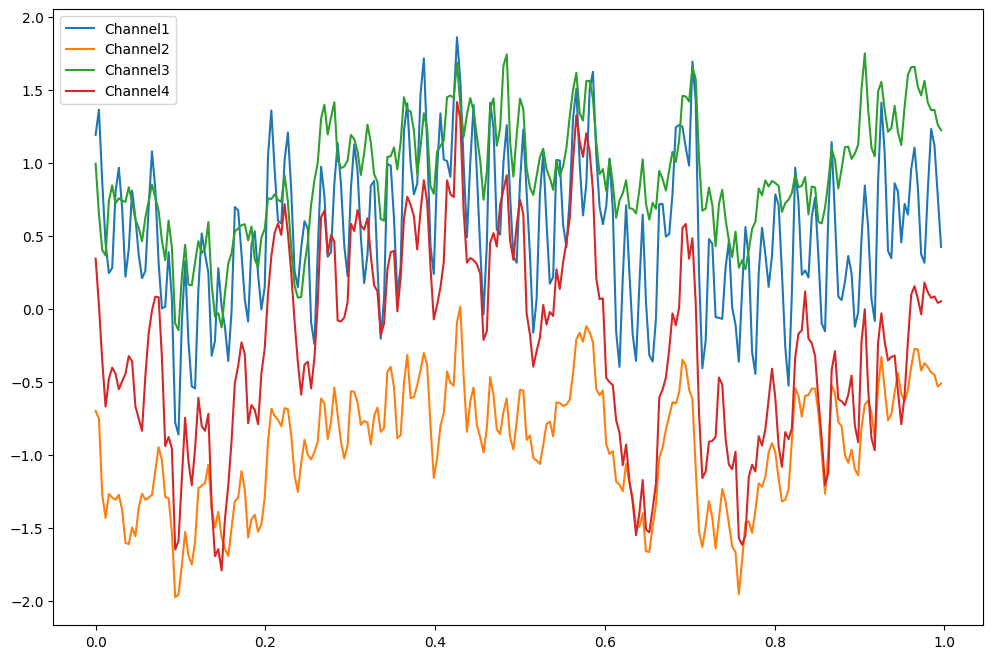

In [10]:
# plot first sample, first four channels
plot_channels(1, X_train[0][:,:4])

In [11]:
del X_trial_train
del X_trial_val
del X_trial_test

## Train model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The program will run on {device}!")

The program will run on cuda!


### Callback functions

In [13]:
def pretrain_callback(model, loss):
    n = model.n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, X_train, y_train[:, 0], X_val, y_val[:, 0], fraction=1)
        print(metrics_dict)
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [14]:
def finetune_callback(model, f1, fraction=1.0):
    n = model.n_epochs
    if model.n_epochs == 1:
        model.finetune_f1 = f1
        torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    # control the saving frequency
    if n % 1 == 0:
        if f1 > model.finetune_f1:
            model.finetune_f1 = f1
            torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    return finetune_callback

## Self-Supervised

In [15]:
start_time = datetime.now()
# Train a COMET model
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
)

epoch_loss_list, epoch_f1_list = model.fit(
    X_train,
    y_train,
    shuffle_function = configs.shuffle_function,
    verbose=configs.verbose,
    n_epochs=configs.n_epochs,
    masks = configs.masks,
    factors = configs.factors
)

end_time = datetime.now()
print(f'Duration: {end_time - start_time}')

Epoch #1: loss=16.17652068418615
{'Accuracy': 0.7505482456140351, 'Precision': 0.7510556427644648, 'Recall': 0.7505482456140351, 'F1': 0.7504221429978393, 'AUROC': 0.8418972664666051, 'AUPRC': 0.8391538915874245}
Epoch #2: loss=13.59088019763722
{'Accuracy': 0.7850877192982456, 'Precision': 0.7851549158918065, 'Recall': 0.7850877192982456, 'F1': 0.7850750575631692, 'AUROC': 0.8680074638350261, 'AUPRC': 0.8644531178447639}
Epoch #3: loss=13.285006410935345
{'Accuracy': 0.7987938596491229, 'Precision': 0.7988545831704897, 'Recall': 0.7987938596491229, 'F1': 0.7987836384857914, 'AUROC': 0.8888816751308095, 'AUPRC': 0.8893273837059705}
Epoch #4: loss=12.627170057857738
{'Accuracy': 0.8053728070175439, 'Precision': 0.8069319254301109, 'Recall': 0.8053728070175439, 'F1': 0.8051253313895624, 'AUROC': 0.8957299361341952, 'AUPRC': 0.8960705427740467}
Epoch #5: loss=11.990643781774184
{'Accuracy': 0.7823464912280702, 'Precision': 0.7916633030086627, 'Recall': 0.7823464912280702, 'F1': 0.78059433

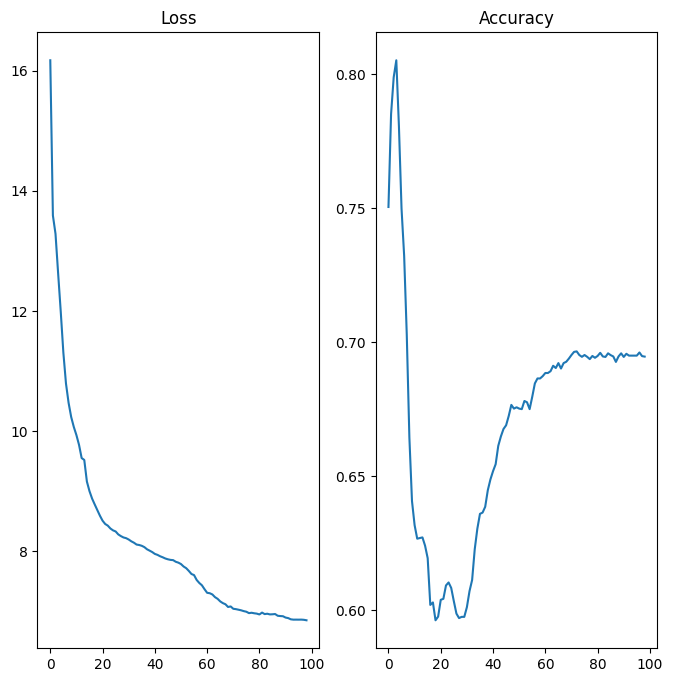

In [16]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Linear evaluation

In [17]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
)

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_val, y_val[:, 0])
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_test, y_test[:, 0])
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

Linear evaluation for validation set
 {'Accuracy': 0.7149122807017544, 'Precision': 0.7926311791553982, 'Recall': 0.7149122807017544, 'F1': 0.6946372207247988, 'AUROC': 0.9360163704216682, 'AUPRC': 0.9364716366728201}


## Full fine-tuning

In [18]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [19]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_100, finetune_epochs=configs.finetune_epochs_100, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_100, fraction=configs.fraction_100, device=device, callback=finetune_callback)

Linear evaluation for test set
 {'Accuracy': 0.662828947368421, 'Precision': 0.7678093663672155, 'Recall': 0.662828947368421, 'F1': 0.6261965020901819, 'AUROC': 0.9202711411203447, 'AUPRC': 0.9223706206375758}

Epoch number: 0
Loss: 0.647641512980828
{'Accuracy': 0.762609649122807, 'Precision': 0.8372286371994572, 'Recall': 0.762609649122807, 'F1': 0.7487087706236368, 'AUROC': 0.987707756232687, 'AUPRC': 0.9878614191948728}
Epoch number: 1
Loss: 0.6371161240797777
{'Accuracy': 0.7933114035087719, 'Precision': 0.8514752133328916, 'Recall': 0.7933114035087719, 'F1': 0.7843914170195354, 'AUROC': 0.982974929786088, 'AUPRC': 0.9835454008298926}
Epoch number: 2
Loss: 0.631146068756397
{'Accuracy': 0.7735745614035088, 'Precision': 0.8424479617375233, 'Recall': 0.7735745614035088, 'F1': 0.7615871152120695, 'AUROC': 0.9677523973722684, 'AUPRC': 0.9660736512236465}
Epoch number: 3
Loss: 0.6270281136035919
{'Accuracy': 0.8042763157894737, 'Precision': 0.8537289838887545, 'Recall': 0.8042763157894

In [20]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_100}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_100} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_100} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

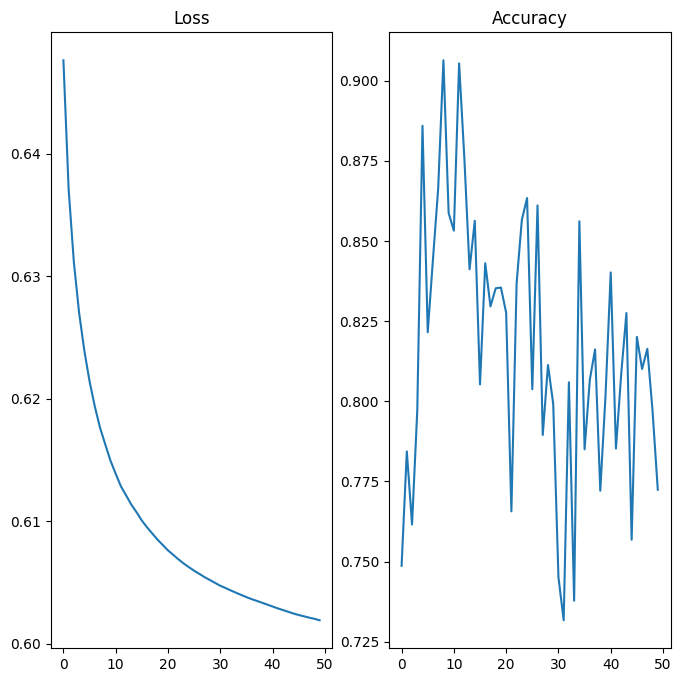

In [21]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Semi-supervised

### 10% label

In [22]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [23]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_10,finetune_epochs=configs.finetune_epochs_10, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_10, fraction=configs.fraction_10, device=device, callback=finetune_callback)

In [24]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_10}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_10} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_10} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

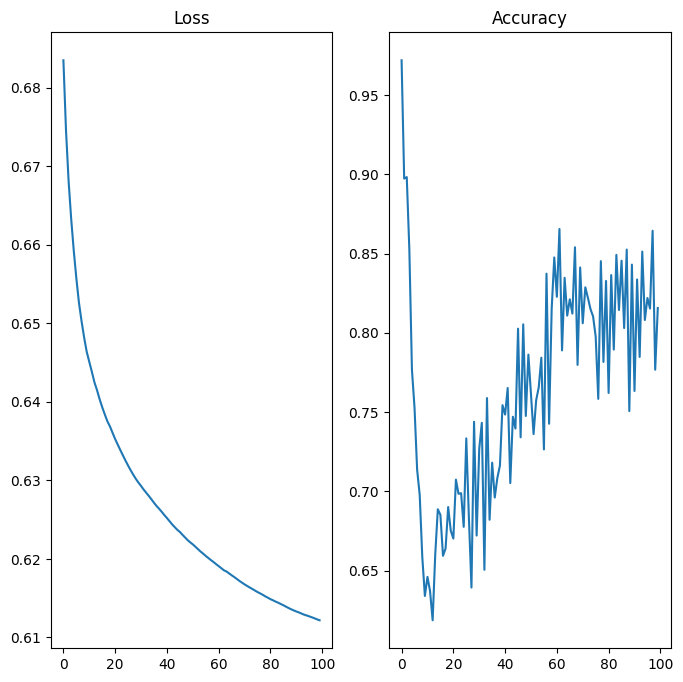

In [25]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [26]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [27]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=configs.finetune_epochs_1, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_1, fraction=configs.fraction_1, device=device, callback=finetune_callback)
# epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=200, num_classes=configs.num_classes, finetune_lr=0.001, fraction=configs.fraction_1, device=device, callback=finetune_callback)
# epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=200, num_classes=configs.num_classes, finetune_lr=0.0001, fraction=configs.fraction_1, device=device, callback=finetune_callback)

In [28]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_1}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_1} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_1} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

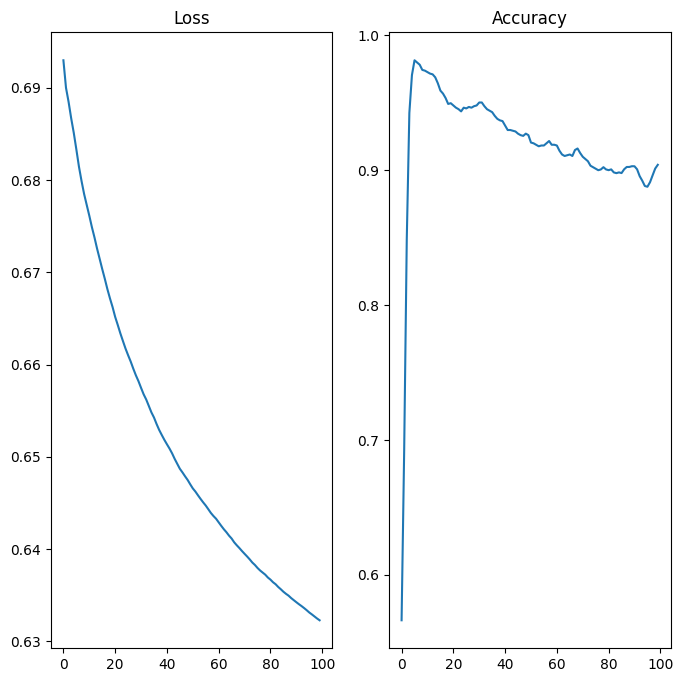

In [29]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [30]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')